# Whistles features analyses

In [1]:
#%%## IMPORTATIONS #####
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils.misc import (NumpyEncoder, import_contours_to_curves,
                             load_spectrogram, plot_contours_on_spectrogram,
                             refine_contours2pixels, qqplot_perso, custom_draftmans_plot)

In [2]:
output_dir = "Whistles_kit/features"
output_img = "Whistles_kit/features/pictures"
#%%## DATA IMPORTATION #####
filtered_data = pd.read_csv(
    os.path.join(output_dir, "whistle_features_filtered.csv"), 
    parse_dates=["datetime"])
better_filtered_data = filtered_data.copy()
better_filtered_data["abs_angular_speeds"] = np.abs(better_filtered_data["angular_speeds"])
better_filtered_data["min_f"] = better_filtered_data["min_f"]/1000
better_filtered_data["mean_f"] = better_filtered_data["mean_f"]/1000
better_filtered_data["max_f"] = better_filtered_data["max_f"]/1000

print("\nSummary of results (after filtering):")
print(f"\tNumber of whistles: {len(better_filtered_data)}")
print(f"\t\t{len(better_filtered_data)-np.isnan(better_filtered_data['angular_speeds']).sum()} with angular speed available")
print(f"\t\t{np.isnan(better_filtered_data['angular_speeds']).sum()} without angular speed")
print(f"\tMin frequency: {better_filtered_data['min_f'].min():.2f}")
print(f"\tMax frequency: {better_filtered_data['max_f'].max():.2f}")
print(f"\tDuration (in seconds): {np.mean(better_filtered_data['duration']):.2f} [Mean]")
print(f"\tSNR (in dB): {np.mean(better_filtered_data['SNR']):.2f} [Mean]")
print(f"\t# harmonics: {np.mean(better_filtered_data['n_harmonics']):.4f} [Mean]")


Summary of results (after filtering):
	Number of whistles: 411
		188 with angular speed available
		223 without angular speed
	Min frequency: 4.75
	Max frequency: 26.16
	Duration (in seconds): 0.50 [Mean]
	SNR (in dB): 15.32 [Mean]
	# harmonics: 0.0438 [Mean]


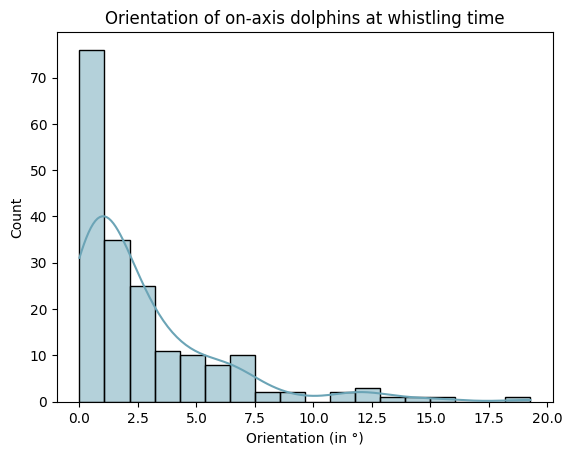

In [3]:
ax = sns.histplot(
    data=better_filtered_data,
    x="abs_angular_speeds", kde=True,
    color="#6ba4b6ff",
)
plt.xlabel("Orientation (in °)")
plt.title("Orientation of on-axis dolphins at whistling time")
ax.get_figure().savefig(os.path.join(output_img, "orientation_distrib.pdf"))
plt.show()
plt.close("all")

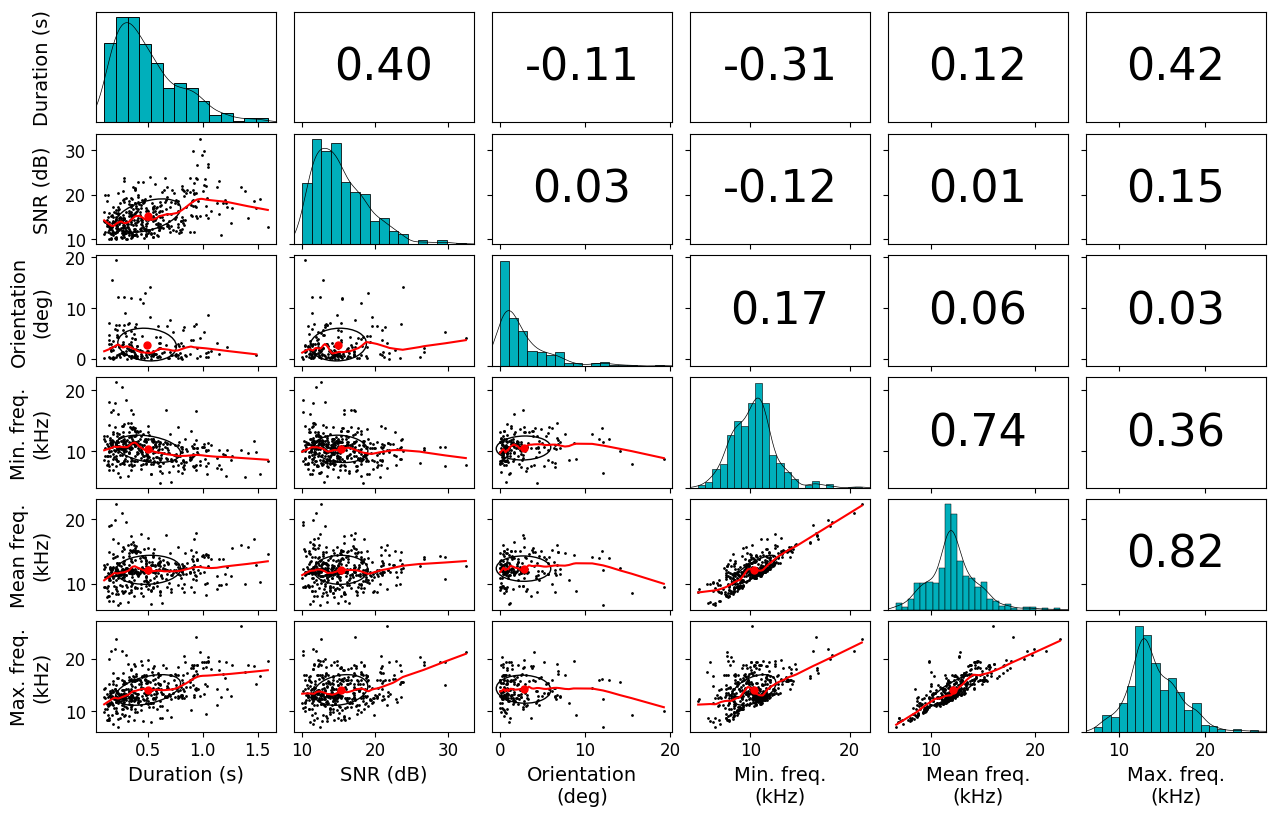

In [4]:
#%%## Draftman's plot #####
fig, axs = custom_draftmans_plot(
    better_filtered_data[['duration', 'SNR', 'abs_angular_speeds', 'min_f', 'mean_f', 'max_f']].copy(),
    old_names = ['duration', 'SNR', 'abs_angular_speeds', 'min_f', 'mean_f', 'max_f'],
    new_names = [
        'Duration (s)', 'SNR (dB)', 'Orientation\n(deg)', 
        'Min. freq.\n(kHz)', 'Mean freq.\n(kHz)', 'Max. freq.\n(kHz)'])
for i in range(6):
    for j in range(6):
        axs[i,j].tick_params(axis='both', which='major', labelsize=12)
        axs[i,j].xaxis.get_label().set_fontsize(14)
        axs[i,j].yaxis.get_label().set_fontsize(14)
        axs[i,j].yaxis.set_label_coords(-0.25,0.5)
plt.show()
fig.savefig(os.path.join(output_img, "draftman_plot.pdf"))

## Annex : draftman's analyses
Introducing the coefs > 0.25 or < -0.25

### SNR-duration
Intuitively, for a same duration, if a whistle is emitted louder, the hydrophone should catch the sound for a longer period of time (because it is then ininterrupted by noise). Let's prove that from our data.

### Duration-freq
From the graphs, there also seems to be a relation between duration and min freq (negative) and max freq (positive).
The longer a whistle is, the less likely it is to be of low frequency, but the less likely it is to be of high frequency. Why ? well good question...

### Frequencies
Obviously, min/max/mean frequencies are correlated.

## SNR-duration

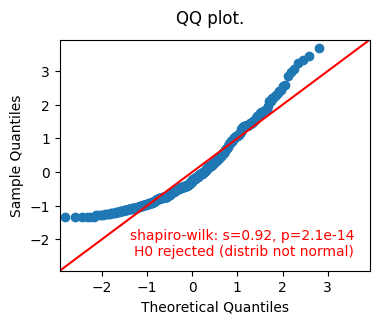

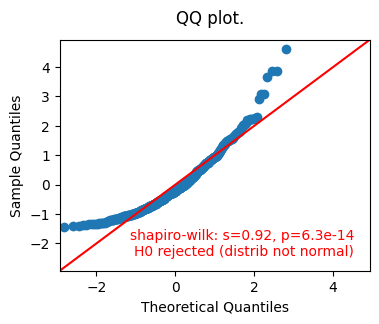

In [5]:
fig = qqplot_perso((better_filtered_data["duration"]))
fig.set_size_inches(4, 3)
plt.show()
fig = qqplot_perso((better_filtered_data["SNR"]))
fig.set_size_inches(4, 3)
plt.show()


In [6]:
# better_filtered_data[["log_SNR", "log_duration"]] = np.log(better_filtered_data[["SNR", "duration"]])
better_filtered_data.reset_index(inplace=True, drop=True)
mod1 = glm(
    "SNR ~ duration + 1",
    data=better_filtered_data,
    family=sm.families.NegativeBinomial()).fit()
# best AIC for Gamma, best BIC for NegativeBinomial
print(mod1.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            3091.3517 
Link Function:      Log              BIC:            -2445.2816
Dependent Variable: SNR              Log-Likelihood: -1543.7   
Date:               2024-07-10 14:52 LL-Null:        -1545.7   
No. Observations:   411              Deviance:       16.323    
Df Model:           1                Pearson chi2:   17.2      
Df Residuals:       409              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept      2.5495    0.1004  25.3824  0.0000  2.3526  2.7463
duration       0.3464    0.1716   2.0190  0.0435  0.0101  0.6826



/home/loic/anaconda3/envs/VIRTUBA/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [7]:
# model shows an effect, now verify hypotheses
fig = qqplot_perso(mod1.resid_response)
print(fig.axes[0].texts[0].get_text())
plt.close(fig)
# normality not expected anw

# What about independance of residuals ?
r, p = stats.kendalltau(mod1.predict(), mod1.resid_response)
print(f"\nkendall-tau: r={r:.2f}, p={p:.2g}")
if p<0.05:
    print("H0 rejected (Presence of correlation)")
else:
    print("H0 cannot be rejected (Absence of correlation)")

shapiro-wilk: s=0.96, p=2.7e-09
H0 rejected (distrib not normal)

kendall-tau: r=-0.02, p=0.5
H0 cannot be rejected (Absence of correlation)


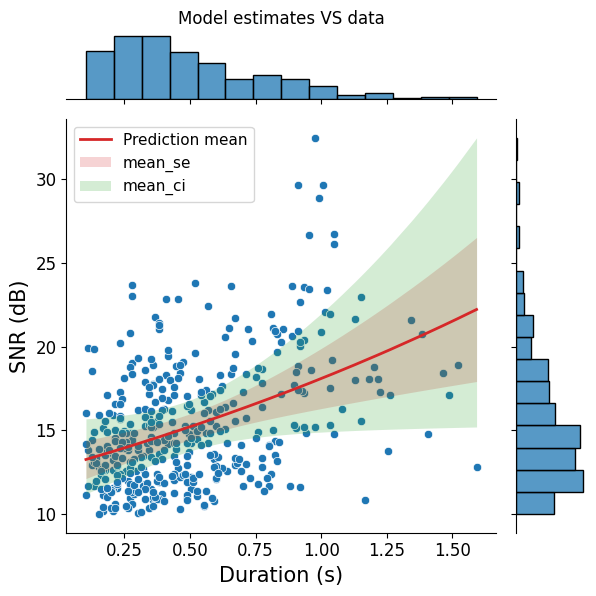

In [8]:
# Show a plot of the results
fig = sns.jointplot(
    x=better_filtered_data["duration"], 
    y=better_filtered_data["SNR"]
)

predictions = mod1.get_prediction(
    better_filtered_data["duration"]).summary_frame()
sns.lineplot(
    x=better_filtered_data["duration"],
    y=predictions["mean"],
    label="Prediction mean",
    color="tab:red", lw=2,
    ax=fig.figure.axes[0]
)
fig.figure.axes[0].fill_between(
    better_filtered_data["duration"].loc[np.argsort(better_filtered_data["duration"])], 
    (predictions["mean"]+predictions["mean_se"]).loc[np.argsort(better_filtered_data["duration"])], 
    (predictions["mean"]-predictions["mean_se"]).loc[np.argsort(better_filtered_data["duration"])], 
    color='tab:red', alpha=.2, lw=0, label="mean_se")
fig.figure.axes[0].fill_between(
    better_filtered_data["duration"].loc[np.argsort(better_filtered_data["duration"])], 
    (predictions["mean_ci_upper"]).loc[np.argsort(better_filtered_data["duration"])], 
    (predictions["mean_ci_lower"]).loc[np.argsort(better_filtered_data["duration"])], 
    color='tab:green', alpha=.2, lw=0, label="mean_ci")
fig.figure.axes[0].tick_params(axis='both', which='major', labelsize=12)
fig.figure.axes[1].set_title("Model estimates VS data")
fig.figure.tight_layout()
plt.legend(fontsize=11)
plt.xlabel("Duration (s)", fontsize=15)
plt.ylabel("SNR (dB)", fontsize=15)
plt.show()
fig.savefig(os.path.join(output_img, "duration_SNR.pdf"))

## Duration-frequency
We'll do it with max_frequency only, it is redundant with min_frequency

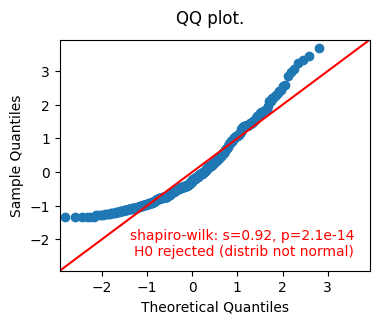

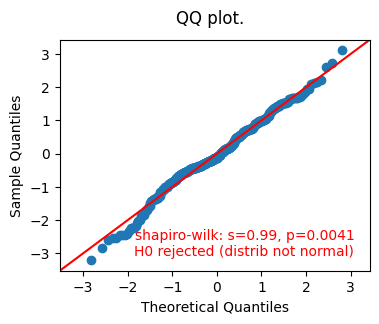

In [9]:
fig = qqplot_perso((better_filtered_data["duration"]))
fig.set_size_inches(4, 3)
plt.show()
fig = qqplot_perso(np.log(better_filtered_data["max_f"]))
fig.set_size_inches(4, 3)
plt.show()

In [10]:
mod2 = glm(
    "max_f ~ duration + 1",
    data=better_filtered_data,
    family=sm.families.NegativeBinomial()).fit()
# best AIC for Gamma, best BIC for NegativeBinomial
print(mod2.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            3023.6197 
Link Function:      Log              BIC:            -2448.2413
Dependent Variable: max_f            Log-Likelihood: -1509.8   
Date:               2024-07-10 14:52 LL-Null:        -1511.2   
No. Observations:   411              Deviance:       13.363    
Df Model:           1                Pearson chi2:   13.5      
Df Residuals:       409              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
----------------------------------------------------------------
Intercept     2.4949    0.1007  24.7740  0.0000   2.2975  2.6922
duration      0.2856    0.1721   1.6598  0.0969  -0.0516  0.6228



/home/loic/anaconda3/envs/VIRTUBA/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


No effect (statistically) of the duration according to this model. It comes at no surprise as the correlation coefficient computed in the draftman's plot are small.

In [11]:
better_filtered_data[["log_SNR", "log_duration"]] = np.log(better_filtered_data[["SNR", "duration"]])
better_filtered_data.reset_index(inplace=True, drop=True)
mod1 = glm(
    "SNR ~ duration + 1",
    data=better_filtered_data,
    family=sm.families.NegativeBinomial()).fit()
# best AIC for Gamma, best BIC for NegativeBinomial
print(mod1.summary2())

               Results: Generalized linear model
Model:              GLM              AIC:            3091.3517 
Link Function:      Log              BIC:            -2445.2816
Dependent Variable: SNR              Log-Likelihood: -1543.7   
Date:               2024-07-10 14:52 LL-Null:        -1545.7   
No. Observations:   411              Deviance:       16.323    
Df Model:           1                Pearson chi2:   17.2      
Df Residuals:       409              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept      2.5495    0.1004  25.3824  0.0000  2.3526  2.7463
duration       0.3464    0.1716   2.0190  0.0435  0.0101  0.6826



/home/loic/anaconda3/envs/VIRTUBA/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


## Whistles VS Orientation

In [12]:
# add categories
better_filtered_data["Orientation"] = [
    "unknown" if boolean
    else "on-axis"
    for boolean in np.isnan(better_filtered_data["angular_speeds"])
]

better_filtered_data.head()

datetime  duration        SNR  signal_dB  angular_speeds  \
0 2021-07-17 15:26:02  0.503994  14.244876 -73.021835             NaN   
1 2021-07-17 15:26:02  0.391995  11.187649 -75.223240             NaN   
2 2021-07-17 15:26:02  0.255997  12.564945 -74.969270             NaN   
3 2021-07-17 15:26:02  0.271997  13.117639 -72.367035             NaN   
4 2021-07-17 15:26:02  0.503994  16.225741 -70.029130             NaN   

       max_f      min_f     mean_f                 ID  n_harmonics  \
0  13.237073  11.894634  12.595339  Line1_20217171526            0   
1  12.643902  10.958049  11.845575  Line2_20217171526            0   
2  13.205854  12.300488  12.665366  Line3_20217171526            0   
3  14.017561  12.456585  13.215954  Line4_20217171526            0   
4  11.988293   8.991220  10.175579  Line6_20217171526            0   

   abs_angular_speeds   log_SNR  log_duration Orientation  
0                 NaN  2.656397     -0.685192     unknown  
1                 NaN  2.414810     -0.936506     unknown  
2                 NaN  2.530911     -1.362590     unknown  
3                 NaN  2.573958     -1.301966     unknown  
4                 NaN  2.786599     -0.685192     unknown

In [13]:
# local function : CDF curves
def cdf_with_thresholds(df, metric, category, unit="", threshold=0.5, verbose=True, hue_order=None):
    histplot = sns.kdeplot(
        data=df, 
        cumulative=True, common_norm=False,
        x=metric, hue=category,
        hue_order=hue_order
    )
    for l, line in enumerate(histplot.get_lines()):
        curve = line.get_xydata()
        # value for 50% density
        x50 = np.interp(threshold, curve[:,1], curve[:,0])
        plt.text(
            .66, (l+1)/20,
            f"X = {x50:.2f}",
            color = line.get_color(),
            transform=histplot.get_figure().get_axes()[0].transAxes
        )
    plt.text(
        .66, (l+2)/20,
        f"P({metric} > X) = {threshold*100:.0f}%",
        transform=histplot.get_figure().get_axes()[0].transAxes
    )
    plt.xlabel(f"{metric} {'('+unit+')' if len(unit)>0 else ''}")

    if verbose:
        sample_args = tuple(df.groupby(category)[metric].apply(list).reset_index()[metric])
        if len(sample_args) == 2:
            u, p = stats.mannwhitneyu(sample_args[0], sample_args[1])
            print(f"Mann-Whitney U test: statistic={u:.2f}, pvalue={p:.2g}")
        else:
            
            h, p = stats.kruskal(*sample_args)
            print(f"Kruskal-Wallis test: statistic={h:.2f}, pvalue={p:.2g}")   

    return histplot

### SNR VS orientation

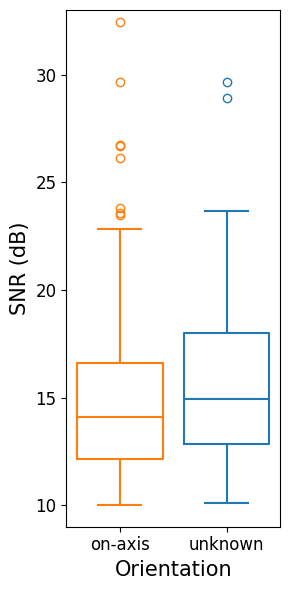

In [36]:
# # normality ?
# qqplot_perso(better_filtered_data["SNR"])
# plt.show()
# Nope. So KW is good.

# SNR 
# cdfplot = cdf_with_thresholds(
#     better_filtered_data, "SNR", "Orientation", 
#     hue_order=["on-axis","unknown"])
# plt.xlabel("SNR (dB)")
# plt.show()
# cdfplot.get_figure().savefig(os.path.join(output_img, "SNR_orientation.pdf"))

fig, ax = plt.subplots(1,1,figsize=(3,6))
sns.boxplot(
    data=better_filtered_data, 
    y="SNR", fill=False,
    x="Orientation", hue="Orientation",
    hue_order=["unknown","on-axis"],
    order=["on-axis","unknown"],
    ax=ax
)

plt.ylabel("SNR (dB)", fontsize=15)
plt.xlabel("Orientation", fontsize=15)
ax.tick_params(which="both", labelsize=12)
plt.ylim((9, 33))
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(output_img, "SNR_orientation_box.pdf"))

Interesting : there is a significant difference between SNR emitted by on-axis dolphins VS unknown (most probably off-axis) dolphins. Let's investigate further by making subsets of the 'on-axis' orientation. Maybe more low-frequencies in on-axis emitted whistles ?

### Mean frequency VS orientation

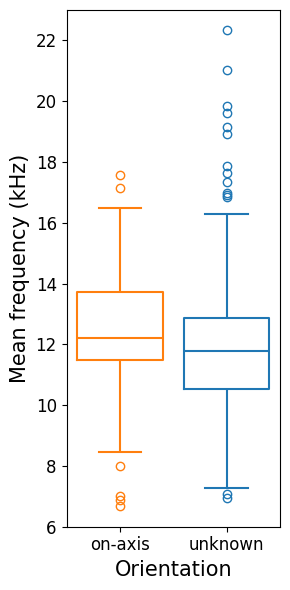

In [37]:
# cdfplot = cdf_with_thresholds(
#     better_filtered_data, "mean_f", "Orientation", 
#     hue_order=["on-axis","unknown"])
# plt.xlabel("Mean frequency (kHz)")
# plt.show()
# cdfplot.get_figure().savefig(os.path.join(output_img, "mean-freq_orientation.pdf"))

fig, ax = plt.subplots(1,1,figsize=(3,6))
sns.boxplot(
    data=better_filtered_data, 
    y="mean_f", fill=False,
    x="Orientation", hue="Orientation",
    hue_order=["unknown","on-axis"],
    order=["on-axis","unknown"],
    ax=ax
)
plt.ylabel("Mean frequency (kHz)", fontsize=15)
plt.xlabel("Orientation", fontsize=15)
ax.tick_params(which="both", labelsize=12)
plt.ylim((6, 23))
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(output_img, "mean-freq_orientation_box.pdf"))

## Frequencies
In published papers, diffusion of whistles is shown in function of frequency ranges. Can we do the same ?

In [16]:
freq_categories = [
    [5000, 8000],
    [8000, 12000],
    [12000, 15000],
    [15000, np.inf],
]
categories = []
for freq in better_filtered_data.mean_f:
    freq = freq*1000
    for f_range in freq_categories:
        if (freq >= f_range[0]) and (freq < f_range[1]):
            if f_range == freq_categories[-1]:
                categories += [str(f_range[0]//1000)+"+ kHz"]
            else:
                categories += [
                    "-".join((np.array(f_range)//1000).astype(int).astype(str)) +
                    " kHz"
                ]
better_filtered_data["Freq. range"] = categories

freq_range_names = [
    str(freq_range[0]//1000) + "-" + str(freq_range[1]//1000) + " kHz"
    if (freq_range[1] != np.inf) else
    str(freq_range[0]//1000) + "+ kHz"
    for freq_range in freq_categories
]

better_filtered_data.head()

datetime  duration        SNR  signal_dB  angular_speeds  \
0 2021-07-17 15:26:02  0.503994  14.244876 -73.021835             NaN   
1 2021-07-17 15:26:02  0.391995  11.187649 -75.223240             NaN   
2 2021-07-17 15:26:02  0.255997  12.564945 -74.969270             NaN   
3 2021-07-17 15:26:02  0.271997  13.117639 -72.367035             NaN   
4 2021-07-17 15:26:02  0.503994  16.225741 -70.029130             NaN   

       max_f      min_f     mean_f                 ID  n_harmonics  \
0  13.237073  11.894634  12.595339  Line1_20217171526            0   
1  12.643902  10.958049  11.845575  Line2_20217171526            0   
2  13.205854  12.300488  12.665366  Line3_20217171526            0   
3  14.017561  12.456585  13.215954  Line4_20217171526            0   
4  11.988293   8.991220  10.175579  Line6_20217171526            0   

   abs_angular_speeds   log_SNR  log_duration Orientation Freq. range  
0                 NaN  2.656397     -0.685192     unknown   12-15 kHz  
1                 NaN  2.414810     -0.936506     unknown    8-12 kHz  
2                 NaN  2.530911     -1.362590     unknown   12-15 kHz  
3                 NaN  2.573958     -1.301966     unknown   12-15 kHz  
4                 NaN  2.786599     -0.685192     unknown    8-12 kHz

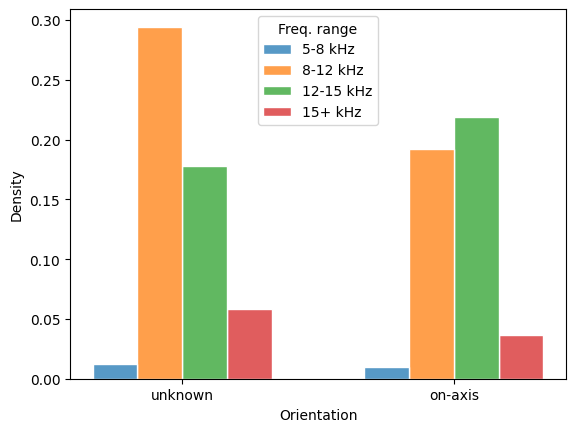

In [17]:
sns.histplot(
    data=better_filtered_data,
    x="Orientation", hue="Freq. range",
    hue_order=freq_range_names,
    fill=True, stat="density", multiple="dodge",
    edgecolor="white", discrete=True, shrink=0.66
)
plt.show()

## Sub-orientations

In [18]:
orientation_limits = [
    [0, 2.5],
    [2.5, 5],
    [5, np.inf],
]
orientation_names = ['< 2.5°', '[2.5, 5]°', '> 5°']

categories = []
for angle in better_filtered_data.abs_angular_speeds:
    if np.isnan(angle):
        categories += ["unknown"]
    else:
        for i, angle_range in enumerate(orientation_limits):
            if (angle >= angle_range[0]) and (angle < angle_range[1]):
                categories += [orientation_names[i]]

better_filtered_data["Orientations"] = categories
data_without_unknowns = better_filtered_data.copy()
data_without_unknowns = data_without_unknowns.dropna(how="any")

print(np.unique(data_without_unknowns["Orientations"], return_counts=True))

(array(['< 2.5°', '> 5°', '[2.5, 5]°'], dtype=object), array([121,  33,  34]))


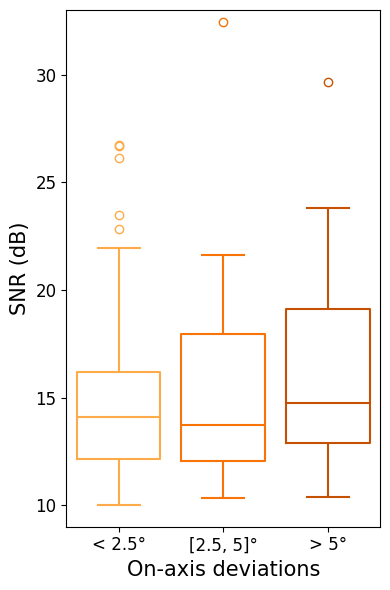

In [33]:
# cdfplot = cdf_with_thresholds(
#     data_without_unknowns, "SNR", "Orientations", 
#     hue_order=['< 2.5°', '[2.5, 5]°', '> 5°']
#     )
# plt.xlabel("SNR (dB)")
# plt.show()
# cdfplot.get_figure().savefig(os.path.join(output_img, "SNR_orientations.pdf"))

fig, ax = plt.subplots(figsize=(4,6))
sns.boxplot(
    data=data_without_unknowns, 
    y="SNR", fill=False,
    x="Orientations", hue="Orientations",
    hue_order=['< 2.5°', '[2.5, 5]°', '> 5°'],
    order=['< 2.5°', '[2.5, 5]°', '> 5°'],
    ax=ax,
    palette=["xkcd:light orange", "xkcd:orange", "xkcd:dark orange"],
)
ax.set_ylabel("SNR (dB)", fontsize=15)
ax.set_xlabel("On-axis deviations", fontsize=15)
ax.tick_params(which="both", labelsize=12)
plt.ylim((9, 33))
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(output_img, "SNR_orientations_box.pdf"))


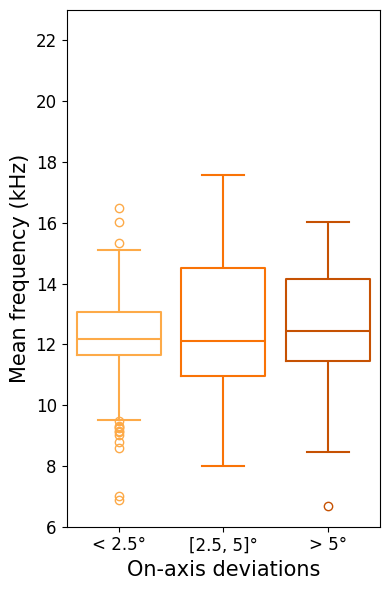

In [35]:
# cdfplot = cdf_with_thresholds(
#     data_without_unknowns, "mean_f", "Orientations", 
#     hue_order=['< 2.5°', '[2.5, 5]°', '> 5°'])
# plt.xlabel("Mean frequency (kHz)")
# plt.show()
# cdfplot.get_figure().savefig(os.path.join(output_img, "mean-freq_orientations.pdf"))

fig, ax = plt.subplots(figsize=(4,6))
sns.boxplot(
    data=data_without_unknowns, 
    y="mean_f", fill=False,
    x="Orientations", hue="Orientations",
    hue_order=['< 2.5°', '[2.5, 5]°', '> 5°'],
    order=['< 2.5°', '[2.5, 5]°', '> 5°'],
    ax=ax,
    palette=["xkcd:light orange", "xkcd:orange", "xkcd:dark orange"],
)
ax.set_ylabel("Mean frequency (kHz)", fontsize=15)
ax.set_xlabel("On-axis deviations", fontsize=15)
ax.tick_params(which="both", labelsize=12)
plt.ylim((6, 23))
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(output_img, "mean-freq_orientations_box.pdf"))

Conclusion : we are not able to differenciate further because the directivity of the echolocation clicks limits us. However, we can affirm that SNR is lower for whistles emitted on-axis that unknown orientations. The explanation lies in the frequencies => unknown orientation whistles have lower mean frequencies (check following graphs) => because highest frequencies were absorbed during transmission i water => so alles good.

## Harmonics VS orientation

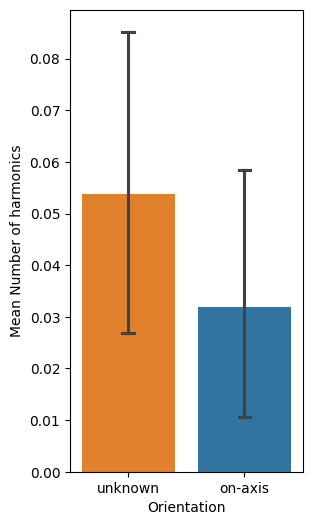

MWU test: statistic=20503.00, pvalue=0.28


In [21]:
better_filtered_data_bis = better_filtered_data.copy()

fig, ax = plt.subplots(figsize=(3, 6))
sns.barplot(
    x='Orientation', y='n_harmonics', data=better_filtered_data_bis, 
    estimator='mean', hue='Orientation', hue_order=["on-axis","unknown"],
    capsize=0.1, errorbar=('ci', 95))
ax.set_ylabel('Mean Number of harmonics')
plt.show()
mwu_args = tuple(better_filtered_data_bis.groupby("Orientation")["n_harmonics"].apply(list).reset_index()["n_harmonics"])
u, p = stats.mannwhitneyu(*mwu_args)
print(f"MWU test: statistic={u:.2f}, pvalue={p:.2g}") 

So, the graph says one thing but the statistic is very clear => no statical difference in the number of harmonics... But since ~10% of the annotated whistles had harmonics, it is likely that there was just too much noise to be more precise.